AutoEncoder Experiments

In [25]:
# %load Experiments/autoExperiment.py
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 10
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("preExperiments")

stats = []
rate = 2

#For each number of layers, new model add layers.
for layer in xrange(0,4):
    #Set here in case we alter it in a layer experiment
    learning_rate = 0.5


    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    logger.info("Starting ")

    #define the model
    model = MLP(cost=cost)

    if layer == 0:
        odim = 800
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
    if layer == 1:
        odim = 600
        model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
    elif layer == 2:
        odim = 400
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
    elif layer == 3:
        odim = 300
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        
    #Add output layer
    model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

    #Set rate scheduler here
    if rate == 1:
        lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
    elif rate == 2:
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    elif rate == 3:
        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs
        lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)
    
    logger.info('Pre-Training started...')
    tr_stats, valid_stats = optimiser.pretrain(model, train_dp, None,0)

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    #Append stats for all test
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

    #Should save rate to specific dictionairy in pickle
    shelve_r['pretrainAuto'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Pre-Training started...
INFO:mlp.optimisers:Max epochs 10
INFO:mlp.optimisers:epochs 0
INFO:mlp.optimisers:Running
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 23.170. Accuracy is 0.80%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 12.804. Accuracy is 1.80%
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 10.040. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 8.090. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 6.671. Accuracy is 0.90%
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 5.805. Accuracy is 1.10%
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 4.910. Accuracy is 1.70%
INFO:mlp.optimisers:Epoch 8: Training cost (ce) is 4.313. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 9: Training cost (ce) is 3.884. Accuracy is 1.60%
INFO:mlp.optimisers:Epoch 10: Training cost (ce) is 3.404. Accuracy is 2.10%
INFO:mlp.optimisers:activations 3
INFO:mlp.optimis

De-Noising AutoEncoder (0.25) Experiments

In [26]:
# %load Experiments/autoExperiment025.py
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 10
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("preExperiments")

stats = []
rate = 2

#For each number of layers, new model add layers.
for layer in xrange(0,4):
    #Set here in case we alter it in a layer experiment
    learning_rate = 0.5


    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    logger.info("Starting ")

    #define the model
    model = MLP(cost=cost)

    if layer == 0:
        odim = 800
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
    if layer == 1:
        odim = 600
        model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
    elif layer == 2:
        odim = 400
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
    elif layer == 3:
        odim = 300
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        
    #Add output layer
    model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

    #Set rate scheduler here
    if rate == 1:
        lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
    elif rate == 2:
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    elif rate == 3:
        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs
        lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)
    
    logger.info('Pre-Training started...')
    tr_stats, valid_stats = optimiser.pretrain(model, train_dp, None,0.25)

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    #Append stats for all test
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

    #Should save rate to specific dictionairy in pickle
    shelve_r['pretrainAuto025'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Pre-Training started...
INFO:mlp.optimisers:Max epochs 10
INFO:mlp.optimisers:epochs 0
INFO:mlp.optimisers:Running
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 25.486. Accuracy is 0.70%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 17.520. Accuracy is 1.20%
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 14.858. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 13.179. Accuracy is 1.25%
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 11.916. Accuracy is 1.10%
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 10.895. Accuracy is 1.05%
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 10.040. Accuracy is 1.15%
INFO:mlp.optimisers:Epoch 8: Training cost (ce) is 9.313. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 9: Training cost (ce) is 8.689. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 10: Training cost (ce) is 8.144. Accuracy is 1.25%
INFO:mlp.optimisers:activations 3
INFO:mlp.opt

De-Noising AutoEncoder (0.5) Experiments

In [27]:
# %load Experiments/autoExperiment05.py
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 10
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("preExperiments")

stats = []
rate = 2

#For each number of layers, new model add layers.
for layer in xrange(0,4):
    #Set here in case we alter it in a layer experiment
    learning_rate = 0.5


    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    logger.info("Starting ")

    #define the model
    model = MLP(cost=cost)

    if layer == 0:
        odim = 800
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
    if layer == 1:
        odim = 600
        model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
    elif layer == 2:
        odim = 400
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
    elif layer == 3:
        odim = 300
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        
    #Add output layer
    model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

    #Set rate scheduler here
    if rate == 1:
        lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
    elif rate == 2:
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    elif rate == 3:
        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs
        lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)
    
    logger.info('Pre-Training started...')
    tr_stats, valid_stats = optimiser.pretrain(model, train_dp, None,0.5)

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    #Append stats for all test
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

    #Should save rate to specific dictionairy in pickle
    shelve_r['pretrainAuto05'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Pre-Training started...
INFO:mlp.optimisers:Max epochs 10
INFO:mlp.optimisers:epochs 0
INFO:mlp.optimisers:Running
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 23.344. Accuracy is 0.55%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 14.254. Accuracy is 0.95%
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 11.223. Accuracy is 1.00%
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 9.541. Accuracy is 1.00%
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 8.328. Accuracy is 1.25%
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 7.407. Accuracy is 1.15%
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 6.711. Accuracy is 1.10%
INFO:mlp.optimisers:Epoch 8: Training cost (ce) is 6.177. Accuracy is 1.35%
INFO:mlp.optimisers:Epoch 9: Training cost (ce) is 5.678. Accuracy is 1.30%
INFO:mlp.optimisers:Epoch 10: Training cost (ce) is 5.264. Accuracy is 1.00%
INFO:mlp.optimisers:activations 3
INFO:mlp.optimis

De-Noising AutoEncoder (0.75) Experiments

In [28]:
# %load Experiments/autoExperiment075.py
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 10
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("preExperiments")

stats = []
rate = 2

#For each number of layers, new model add layers.
for layer in xrange(0,4):
    #Set here in case we alter it in a layer experiment
    learning_rate = 0.5


    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    logger.info("Starting ")

    #define the model
    model = MLP(cost=cost)

    if layer == 0:
        odim = 800
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
    if layer == 1:
        odim = 600
        model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
    elif layer == 2:
        odim = 400
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
    elif layer == 3:
        odim = 300
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        
    #Add output layer
    model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

    #Set rate scheduler here
    if rate == 1:
        lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
    elif rate == 2:
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    elif rate == 3:
        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs
        lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)
    
    logger.info('Pre-Training started...')
    tr_stats, valid_stats = optimiser.pretrain(model, train_dp, None,0.75)

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    #Append stats for all test
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

    #Should save rate to specific dictionairy in pickle
    shelve_r['pretrainAuto075'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Pre-Training started...
INFO:mlp.optimisers:Max epochs 10
INFO:mlp.optimisers:epochs 0
INFO:mlp.optimisers:Running
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 23.639. Accuracy is 0.65%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 12.892. Accuracy is 1.00%
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 9.957. Accuracy is 1.05%
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 8.176. Accuracy is 0.75%
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 7.021. Accuracy is 1.00%
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 6.098. Accuracy is 1.40%
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 5.337. Accuracy is 1.70%
INFO:mlp.optimisers:Epoch 8: Training cost (ce) is 4.688. Accuracy is 1.40%
INFO:mlp.optimisers:Epoch 9: Training cost (ce) is 4.195. Accuracy is 1.40%
INFO:mlp.optimisers:Epoch 10: Training cost (ce) is 3.919. Accuracy is 1.35%
INFO:mlp.optimisers:activations 3
INFO:mlp.optimise

Cross-Entropy Greedy Experiments

In [29]:
# %load Experiments/ceExperiment.py
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 10
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("preExperiments")

stats = []
rate = 2

#For each number of layers, new model add layers.
for layer in xrange(0,4):
    #Set here in case we alter it in a layer experiment
    learning_rate = 0.5


    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    logger.info("Starting ")

    #define the model
    model = MLP(cost=cost)

    if layer == 0:
        odim = 800
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
    if layer == 1:
        odim = 600
        model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
    elif layer == 2:
        odim = 400
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
    elif layer == 3:
        odim = 300
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        
    #Add output layer
    model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

    #Set rate scheduler here
    if rate == 1:
        lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
    elif rate == 2:
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    elif rate == 3:
        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs
        lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)
    
    logger.info('Pre-Training started...')
    tr_stats, valid_stats = optimiser.pretrain_discriminative(model, train_dp, None)

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    #Append stats for all test
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

    #Should save rate to specific dictionairy in pickle
    shelve_r['pretrainCE'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Pre-Training started...
INFO:mlp.optimisers:Max epochs 10
INFO:mlp.optimisers:epochs 0
INFO:mlp.optimisers:Running
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.781. Accuracy is 50.10%
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.614. Accuracy is 81.50%
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.410. Accuracy is 87.60%
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.304. Accuracy is 90.60%
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 0.232. Accuracy is 93.30%
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 0.177. Accuracy is 95.50%
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 0.135. Accuracy is 97.50%
INFO:mlp.optimisers:Epoch 8: Training cost (ce) is 0.103. Accuracy is 98.50%
INFO:mlp.optimisers:Epoch 9: Training cost (ce) is 0.079. Accuracy is 99.20%
INFO:mlp.optimisers:Epoch 10: Training cost (ce) is 0.061. Accuracy is 99.40%
INFO:mlp.optimisers:activations 3
INFO:mlp.

Normal Experiment

In [30]:
# %load Experiments/ceExperiment.py
from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 10
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.00
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("preExperiments")

stats = []
rate = 2

#For each number of layers, new model add layers.
for layer in xrange(0,4):
    #Set here in case we alter it in a layer experiment
    learning_rate = 0.5


    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    logger.info("Starting ")

    #define the model
    model = MLP(cost=cost)

    if layer == 0:
        odim = 800
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
    if layer == 1:
        odim = 600
        model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
    elif layer == 2:
        odim = 400
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
    elif layer == 3:
        odim = 300
        model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
        
    #Add output layer
    model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

    #Set rate scheduler here
    if rate == 1:
        lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
    elif rate == 2:
        lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
    elif rate == 3:
        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs
        lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                          min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dp_scheduler,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)
    
    logger.info('No Pre-Training started...')

    logger.info('Training started...')
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

    logger.info('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    #Append stats for all test
    stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

    #Should save rate to specific dictionairy in pickle
    shelve_r['pretrainNormal'+str(layer)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:No Pre-Training started...
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.624. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 3.053. Accuracy is 58.00%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.600. Accuracy is 81.41%
INFO:mlp.optimisers:Epoch 1: Took 8 seconds. Training speed 402 pps. Validation speed 1888 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.518. Accuracy is 83.50%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.497. Accuracy is 85.12%
INFO:mlp.optimisers:Epoch 2: Took 8 seconds. Training speed 422 pps. Validation speed 1928 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.324. Accuracy is 91.00%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.458. Accuracy is 85.38%
INFO:mlp.optimisers:Ep

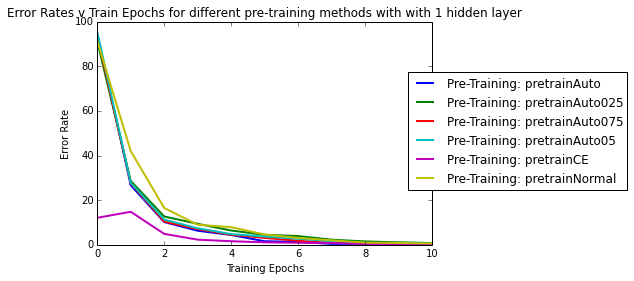

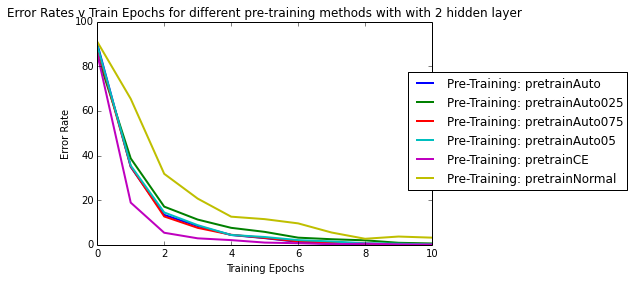

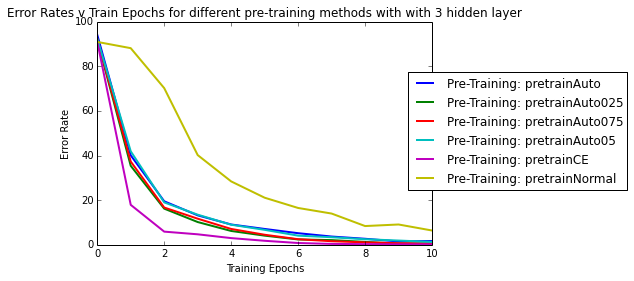

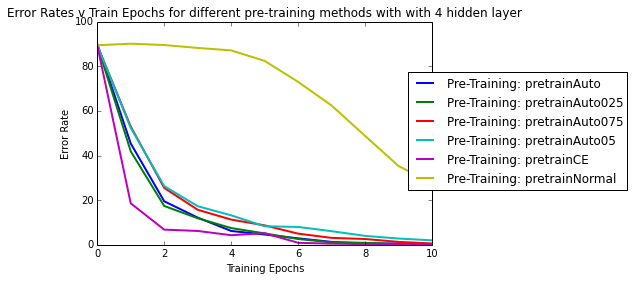

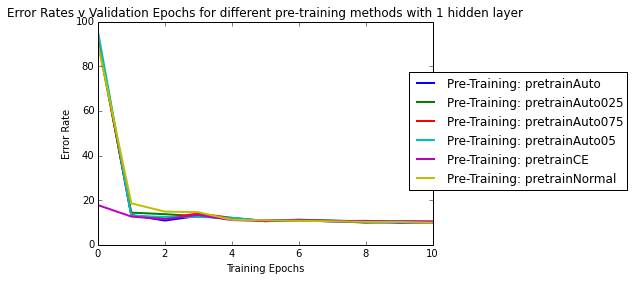

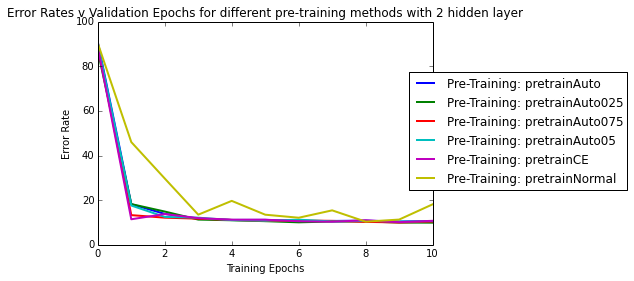

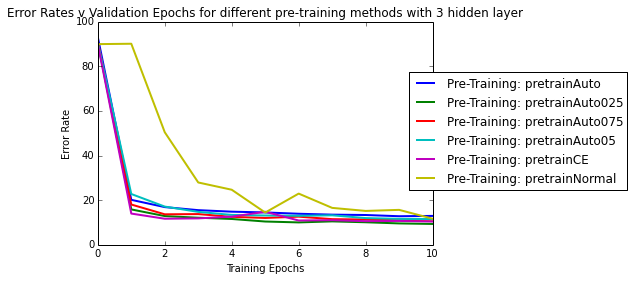

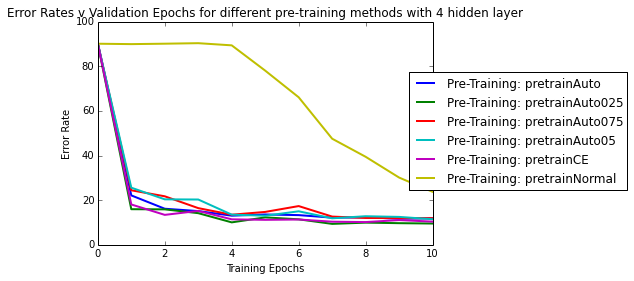

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

#Open file to save to
shelve_p = shelve.open("preExperiments")
x = range(0,11)

#Go through training list and output the stats in a graph.
#Make sure you run the above cell first.
train_cont = ['pretrainAuto','pretrainAuto025', 'pretrainAuto075', 'pretrainAuto05' ,'pretrainCE', 'pretrainNormal']

for i in xrange(0,4):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][0]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x, train_error, lw=2, label="Pre-Training: "+ str(train_cont[idx]))


    plt.title("Error Rates v Train Epochs for different pre-training methods with with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()
    
for i in xrange(0,4):
    for idx,lists in enumerate(train_cont):
        train_error = []
        for inner_list in shelve_p[lists+str(i)][1]:
            train_error.append(100-(inner_list[1]*100.))
        plt.plot(x, train_error, lw=2, label="Pre-Training: "+ str(train_cont[idx]))


    plt.title("Error Rates v Validation Epochs for different pre-training methods with "+str(i+1)+" hidden layer")
    plt.xlabel('Training Epochs')
    plt.legend
    plt.legend(bbox_to_anchor=(1.6, 0.8))
    plt.ylabel('Error Rate')
    plt.show()

In [33]:
#Open file to save to
shelve_p = shelve.open("preExperiments")

print shelve_p

{'pretrainAuto3': ([(2.3170532965174711, 0.099999999999999895), (1.4337177895362356, 0.54600000000000004), (0.6337417827312618, 0.80499999999999983), (0.40707938751166445, 0.87800000000000022), (0.25347051035714463, 0.93799999999999994), (0.17034541987304938, 0.95400000000000018), (0.12149018432474422, 0.97100000000000009), (0.075312622395995468, 0.98700000000000032), (0.049903986834113373, 0.99400000000000011), (0.03547283385643224, 0.99400000000000011), (0.02673742554506385, 0.99800000000000011)], [(2.3195188489593952, 0.095600000000000004), (0.73138256752401654, 0.77869999999999995), (0.53044987578744551, 0.83840000000000003), (0.49046704050487688, 0.84889999999999999), (0.43373195266871245, 0.86950000000000005), (0.46599872380477164, 0.86419999999999997), (0.46402251825749691, 0.86699999999999999), (0.44437333313686223, 0.87829999999999997), (0.45225041696286461, 0.87680000000000002), (0.44246534029556006, 0.88300000000000001), (0.44999783391011022, 0.88119999999999998)], (0.465932